In [3]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import ess
import sys
sys.path.append(os.path.join(os.environ['UNCERTAINTY_REPO'], 'bpe', 'simulation'))  # Cantera simulation
import simulation
import yaml
import logging

import importlib
importlib.reload(simulation)

import matplotlib.pyplot as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend inline version unknown.


In [4]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [20]:
working_dir = '/scratch/harris.se/guassian_scratch/mk3_runs/ct_20260128'
working_dir = '/scratch/harris.se/guassian_scratch/mk3_runs/cpox_20260130/'
working_dir = '/scratch/harris.se/guassian_scratch/mk3_runs/cpox_20260131/'

In [21]:
sim_info_yaml = os.path.join(working_dir, 'sim_info.yaml')
with open(sim_info_yaml) as f:
    sim_info = yaml.safe_load(f)

In [7]:
sim_info

{'out_gas_indices': [4, 3, 7, 8, 5, 6],
 'out_gas_names': ['O2', 'CH4', 'H2', 'CO', 'CO2', 'H2O'],
 'parameter_names': ['X(1)',
  'HX(21)',
  'CO2X(22)',
  'O2(3) + 2 X(1) <=> 2 OX(24)',
  'CO(7) + X(1) <=> COX(23)',
  'H2(6) + 2 X(1) <=> 2 HX(21)',
  'CO2(4) + X(1) <=> CO2X(22)',
  'COX(23) + OX(24) <=> CO2X(22) + X(1)'],
 'prior_reaction_indices': [0, 11, 14, 17, 28],
 'prior_species_indices': [10, 4, 11],
 'sample_distances': [0.0001,
  0.0007500000000000001,
  0.0014000000000000002,
  0.00205,
  0.0027,
  0.00335,
  0.004,
  0.0066,
  0.01]}

In [31]:
# laod chain and logP
chain0 = ess.flatten_chain(np.load(os.path.join(working_dir, 'results', 'chain_0.npy')))
chain1 = ess.flatten_chain(np.load(os.path.join(working_dir, 'results', 'chain_1.npy')))
chain = np.concatenate((chain0, chain1))

In [32]:
chain.shape

(6816, 8)

In [33]:
# laod chain and logP
logP0 = ess.flatten_logP(np.load(os.path.join(working_dir, 'results', 'logPs_0.npy')))
logP1 = ess.flatten_logP(np.load(os.path.join(working_dir, 'results', 'logPs_1.npy')))

logP = np.concatenate((logP0, logP1))

In [34]:
logP.shape

(6816,)

In [12]:
np.max(logP)

np.float64(178.41719859732638)

In [35]:
MAP_index = np.argmax(logP)

In [36]:
MAP_index

np.int64(2080)

In [15]:
MAP_params = chain[MAP_index, :]

In [16]:
MAP_params

array([-4.51988262e+04, -2.62122515e+04,  2.83955257e+03,  6.16977478e+00,
        1.89534828e+00,  6.34038495e-01, -4.53814321e+00,  1.58648549e+00])

In [17]:
mech_yaml = os.path.join(working_dir, 'chem_annotated.yaml')
gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])

In [18]:
gas_out, surf_out, gas_rates, surf_rates = simulation.run_simulation(mech_yaml)

Text(0.5, 1.0, 'Base case')

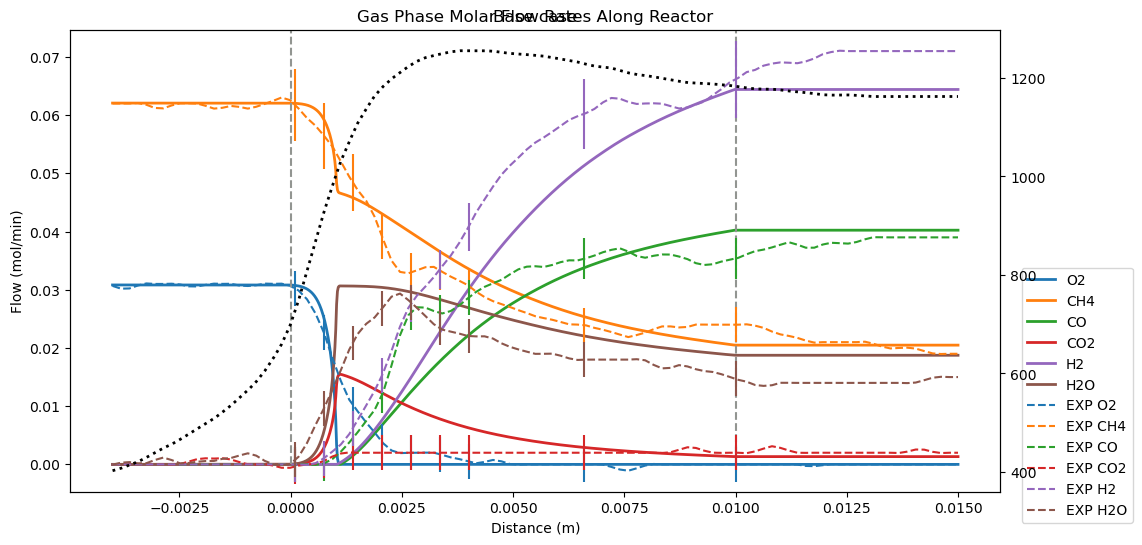

In [17]:
fig, ax = simulation.plot_gas_results(gas_out, gas)
# simulation.plot_gas_results(gas_out, gas)
experiment_csv = os.path.join(working_dir, 'experiment.csv')
experiment_uncertainty_csv = os.path.join(working_dir, 'experiment_uncertainty.csv')

experiment_df = pd.read_csv(experiment_csv)
experiment_uncertainty_df = pd.read_csv(experiment_uncertainty_csv)

# # ------------------------ Plot the experiment to show which points we picked ---------------#
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
species_headers = ['O2 (mol/min)', 'CH4 (mol/min)', 'CO (mol/min)',
       'CO2 (mol/min)', 'H2 (mol/min)', 'H2O (mol/min)']


for i in range(len(species_headers)):
    ax.errorbar(
        sim_info['sample_distances'],
        experiment_df[species_headers[i]].values,
        yerr=experiment_uncertainty_df[species_headers[i]].values,
        color=colors[i],
        label='_no_label',
        fmt='none'
    )
plt.title('Base case')



In [18]:
MAP_params

array([-4.51988262e+04, -2.62122515e+04,  2.83955257e+03,  6.16977478e+00,
        1.89534828e+00,  6.34038495e-01, -4.53814321e+00,  1.58648549e+00])

In [36]:
LL_params = chain[1996]

In [19]:
chain[1996]

array([-4.93870678e+04, -2.96167211e+04, -8.14094350e+03,  5.84669757e+00,
        1.93019925e+00,  4.25714096e-01, -4.44323553e+00,  1.75925128e+00])

In [1]:
[-4.50913094e+04, -2.67473891e+04,  3.12519964e+03,  6.21938796e+00,
        1.88412886e+00,  6.66995204e-01, -4.58455968e+00,  1.62724922e+00]

[-45091.3094,
 -26747.3891,
 3125.19964,
 6.21938796,
 1.88412886,
 0.666995204,
 -4.58455968,
 1.62724922]

In [26]:
LL_params = np.array([-4.93870678e+04, -2.96167211e+04, -8.14094350e+03,  5.84669757e+00,
        1.93019925e+00,  4.25714096e-01, -4.44323553e+00,  1.75925128e+00])

In [28]:
sim_info

{'out_gas_indices': [4, 3, 7, 8, 5, 6],
 'out_gas_names': ['O2', 'CH4', 'H2', 'CO', 'CO2', 'H2O'],
 'parameter_names': ['X(1)',
  'HX(21)',
  'CO2X(22)',
  'O2(3) + 2 X(1) <=> 2 OX(24)',
  'CO(7) + X(1) <=> COX(23)',
  'H2(6) + 2 X(1) <=> 2 HX(21)',
  'CO2(4) + X(1) <=> CO2X(22)',
  'COX(23) + OX(24) <=> CO2X(22) + X(1)'],
 'prior_reaction_indices': [0, 11, 14, 17, 28],
 'prior_species_indices': [10, 4, 11],
 'sample_distances': [0.0001,
  0.0007500000000000001,
  0.0014000000000000002,
  0.00205,
  0.0027,
  0.00335,
  0.004,
  0.0066,
  0.01]}

In [29]:
thermo_perturb = {}
for i, param in enumerate(LL_params[:len(sim_info['prior_species_indices'])]):
    thermo_perturb[sim_info['prior_species_indices'][i]] = param  # expecting units of J/mol

kinetics_perturb = {}
for i, param in enumerate(LL_params[len(sim_info['prior_species_indices']):]):
    kinetics_perturb[sim_info['prior_reaction_indices'][i]] = np.float_power(10.0, param)  # expecting units of multiplier

gas_out, surf_out, gas_rates, surf_rates = simulation.run_simulation(
    mech_yaml,
    surf_thermo_perturb=thermo_perturb,
    surf_kinetics_perturb=kinetics_perturb,
)

Text(0.5, 1.0, '                               map')

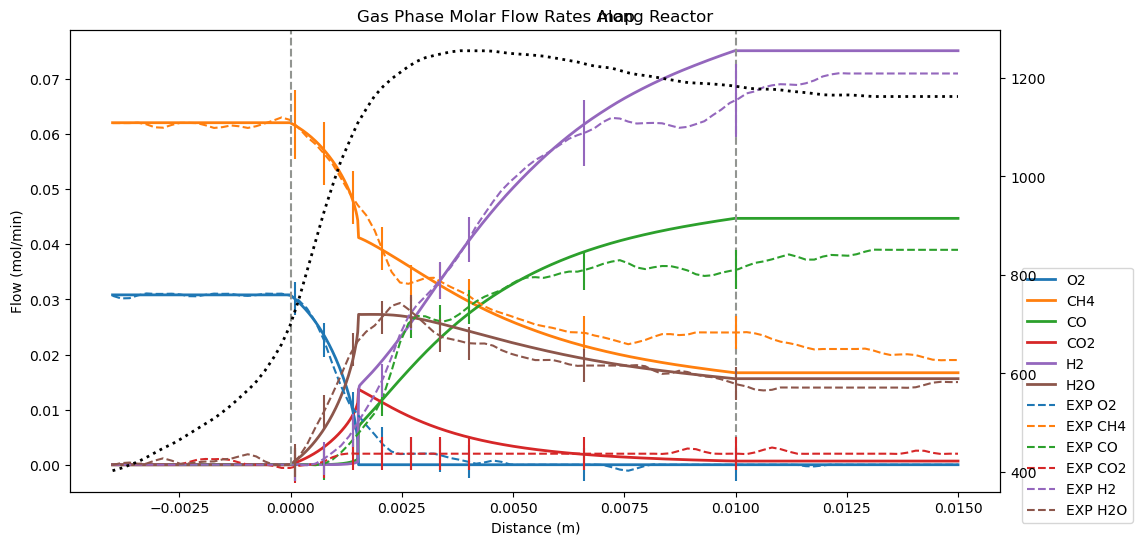

In [30]:
fig, ax = simulation.plot_gas_results(gas_out, gas)
# simulation.plot_gas_results(gas_out, gas)
experiment_csv = os.path.join(working_dir, 'experiment.csv')
experiment_uncertainty_csv = os.path.join(working_dir, 'experiment_uncertainty.csv')

experiment_df = pd.read_csv(experiment_csv)
experiment_uncertainty_df = pd.read_csv(experiment_uncertainty_csv)
species_headers = ['O2 (mol/min)', 'CH4 (mol/min)', 'CO (mol/min)',
       'CO2 (mol/min)', 'H2 (mol/min)', 'H2O (mol/min)']
# # ------------------------ Plot the experiment to show which points we picked ---------------#
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(species_headers)):
    ax.errorbar(
        sim_info['sample_distances'],
        experiment_df[species_headers[i]].values,
        yerr=experiment_uncertainty_df[species_headers[i]].values,
        color=colors[i],
        label='_no_label',
        fmt='none'
    )
plt.title('                               map')

# Plot MAP

In [37]:
MAP_index = np.argmax(logP)
MAP_params = chain[MAP_index, :]

In [38]:
thermo_perturb = {}
for i, param in enumerate(MAP_params[:len(sim_info['prior_species_indices'])]):
    thermo_perturb[sim_info['prior_species_indices'][i]] = param  # expecting units of J/mol

kinetics_perturb = {}
for i, param in enumerate(MAP_params[len(sim_info['prior_species_indices']):]):
    kinetics_perturb[sim_info['prior_reaction_indices'][i]] = np.float_power(10.0, param)  # expecting units of multiplier

gas_out, surf_out, gas_rates, surf_rates = simulation.run_simulation(
    mech_yaml,
    surf_thermo_perturb=thermo_perturb,
    surf_kinetics_perturb=kinetics_perturb,
)

Text(0.5, 1.0, '                               map')

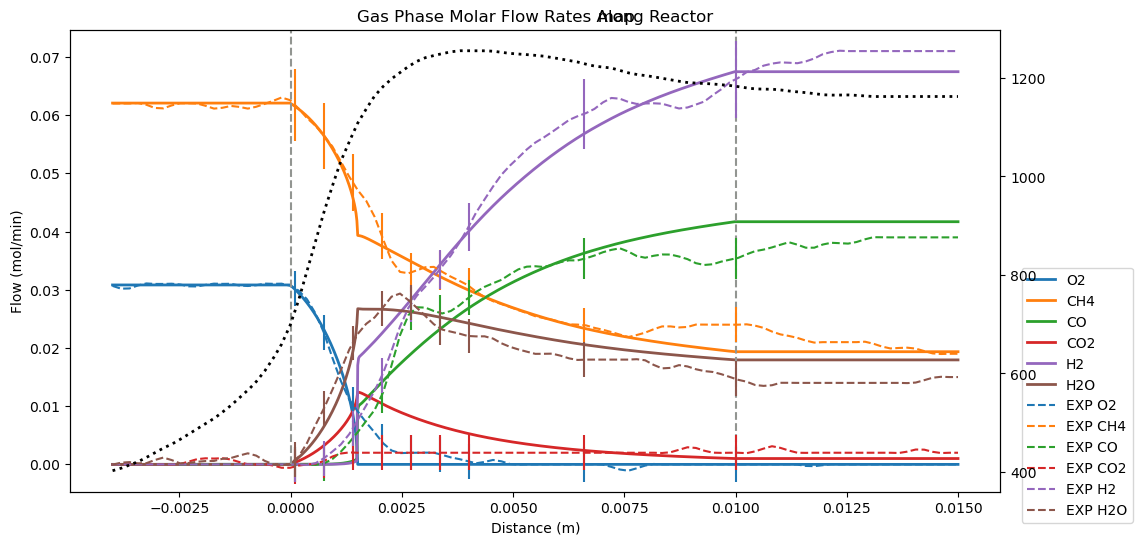

In [39]:
fig, ax = simulation.plot_gas_results(gas_out, gas)
# simulation.plot_gas_results(gas_out, gas)
experiment_csv = os.path.join(working_dir, 'experiment.csv')
experiment_uncertainty_csv = os.path.join(working_dir, 'experiment_uncertainty.csv')

experiment_df = pd.read_csv(experiment_csv)
experiment_uncertainty_df = pd.read_csv(experiment_uncertainty_csv)
species_headers = ['O2 (mol/min)', 'CH4 (mol/min)', 'CO (mol/min)',
       'CO2 (mol/min)', 'H2 (mol/min)', 'H2O (mol/min)']
# # ------------------------ Plot the experiment to show which points we picked ---------------#
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(species_headers)):
    ax.errorbar(
        sim_info['sample_distances'],
        experiment_df[species_headers[i]].values,
        yerr=experiment_uncertainty_df[species_headers[i]].values,
        color=colors[i],
        label='_no_label',
        fmt='none'
    )
plt.title('                               map')